In [1]:
%matplotlib inline
#import warnings; warnings.simplefilter('always')

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from scipy import optimize
from scipy.optimize import curve_fit

import os
from functools import reduce
import scipy
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats import expon
from scipy.stats.mstats import gmean

from scipy import optimize
from scipy.optimize import curve_fit

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import math

/Users/eisen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Modeling transcriptional bursting 

Some assumptions:


In [5]:
mean_on_time = 60
mean_off_time = 30

kon = 1/mean_on_time
koff = 1/mean_off_time

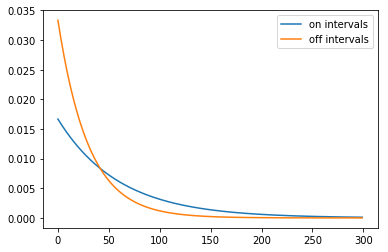

In [6]:
time_range = [0,300]
time_interval = 1
times = np.arange(time_range[0],time_range[1],time_interval)

plt.plot(times,expon.pdf(times,loc=0,scale=mean_on_time),label='on intervals')
plt.plot(times,expon.pdf(times,loc=0,scale=mean_off_time),label='off intervals')
plt.legend()

In [7]:
# in seconds

time_range = [0,1200]
time_interval = 1
times = np.arange(time_range[0],time_range[1],time_interval)

# sample intervals

promoter_state = 0
t = 0

on_intervals = []

while t < time_range[1]:
    if promoter_state == 0:
        scale = mean_off_time
        off_interval = float(expon.rvs(loc=0,scale=scale,size=1))
        t0 = t
        t = t + off_interval
        if t >= time_range[1]:
            t = time_range[1]
        promoter_state = 1
        print ("0 --> 1", t)
    else:
        scale = mean_on_time
        on_interval = float(expon.rvs(loc=0,scale=scale,size=1))
        t0 = t
        t = t + on_interval
        if t >= time_range[1]:
            t = time_range[1]
        on_intervals.append([t0,t])

        promoter_state = 0
        print ("1 --> 0", t)
        
on_density = np.zeros(len(times))

for on in on_intervals:
    sbin = int(np.floor(on[0]))
    ebin = int(np.floor(on[1]))
    
    if sbin == ebin:
        on_density[sbin] += ebin-sbin
    else:
        on_density[sbin] += 1.0 - (on[0] - np.floor(on[0]))
        for i in range(sbin + 1, ebin):
            on_density[i] += 1.0
        
        if ebin < len(on_density):
            on_density[ebin] += on[1] - np.floor(on[1])


0 --> 1 12.719180250160806
1 --> 0 108.05112404563341
0 --> 1 120.34263960099284
1 --> 0 125.52001956649141
0 --> 1 149.87666736576165
1 --> 0 185.95481432354018
0 --> 1 267.71241100090816
1 --> 0 417.56426770624256
0 --> 1 442.27767310099665
1 --> 0 507.2171019286509
0 --> 1 542.9492410739778
1 --> 0 575.3568542050823
0 --> 1 596.7565229433135
1 --> 0 610.2901898994854
0 --> 1 616.5084267918004
1 --> 0 726.5778441175263
0 --> 1 728.6069711470163
1 --> 0 768.1245147570772
0 --> 1 818.9854015368024
1 --> 0 849.8667197832807
0 --> 1 852.4431355043367
1 --> 0 869.525782560971
0 --> 1 875.5124468109157
1 --> 0 981.9775561591887
0 --> 1 1017.7736318227652
1 --> 0 1037.6083010724258
0 --> 1 1053.361150060199
1 --> 0 1143.4777722549961
0 --> 1 1200


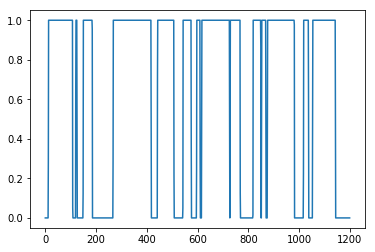

In [8]:
plt.plot(on_density)

In [9]:
def discretize_ranges(start,end,interval,ranges):

    bins = int(np.round(((end-start)/interval),0)) 
        
    discrete = np.zeros(bins)
    
    for r in ranges:
        sbin = int(r[0]/interval)
        ebin = int(r[1]/interval)

        if sbin < bins:
            if sbin == ebin:
                discrete[sbin] += r[1] - r[0]
            else:
                discrete[sbin] += interval - (r[0] - sbin * interval)
                for i in range(sbin + 1, min(ebin,bins)):
                    discrete[i] += interval

                if ebin < bins:
                    discrete[ebin] += r[1] - ebin * interval
    return discrete

When promoter is on it loads polymerases at a fixed rate -- let's say 1 every 10s 

Polymerases move at ~3000 bp / minute, or around 50 bp / second

In [10]:
np.floor(1.4)

1.0

In [11]:
polymerase_interval = 10
polymerase_times = []

for on in on_intervals:
    interval_start = on[0]
    interval_end = on[1]
    
    new_polymerases = np.arange(interval_start,interval_end,10.0)
    for p in new_polymerases:
        polymerase_times.append(p)


In [12]:
polymerase_interval = 10

polymerase_times = []
last_polymerase = -polymerase_interval

for on in on_intervals:
    interval_start = max(last_polymerase + polymerase_interval,on[0])
    interval_end = on[1]
    
    new_polymerases = np.arange(interval_start,interval_end,10.0)
    for p in new_polymerases:
        polymerase_times.append(p)
    if len(new_polymerases) > 0:
        last_polymerase = new_polymerases[-1]

In [13]:
polymerase_speed = 50
gene_length = 6000
polymerase_transit_time = gene_length / polymerase_speed

In [14]:
polymerase_intervals = []

for p in polymerase_times:
    polymerase_intervals.append([p,p+polymerase_transit_time])
    

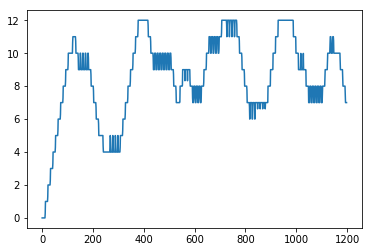

In [15]:
plt.plot(discretize_ranges(1,1200,1,polymerase_intervals))

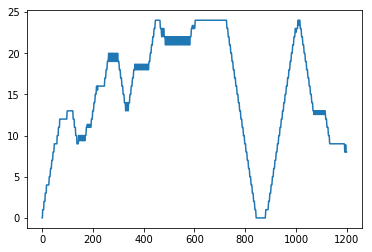

In [16]:
mean_on_time = 60
mean_off_time = 30

time_range = [0,1200]
time_interval = 1
polymerase_interval = 5

polymerase_speed = 50
gene_length = 6000
polymerase_transit_time = gene_length / polymerase_speed

times = np.arange(time_range[0],time_range[1],time_interval)

# sample intervals

promoter_state = 0
t = 0

on_intervals = []

while t < time_range[1]:
    if promoter_state == 0:
        scale = mean_off_time
        off_interval = float(expon.rvs(loc=0,scale=scale,size=1))
        t0 = t
        t = t + off_interval
        if t >= time_range[1]:
            t = time_range[1]
        promoter_state = 1
    
    else:
        scale = mean_on_time
        on_interval = float(expon.rvs(loc=0,scale=scale,size=1))
        t0 = t
        t = t + on_interval
        if t >= time_range[1]:
            t = time_range[1]
        on_intervals.append([t0,t])

        promoter_state = 0
        
promoter_state_density = discretize_ranges(time_range[0],time_range[1],time_interval,on_intervals)


polymerase_intervals = []
last_polymerase = -polymerase_interval

for on in on_intervals:
    interval_start = max(last_polymerase + polymerase_interval,on[0])
    interval_end = on[1]
    
    new_polymerases = np.arange(interval_start,interval_end, polymerase_interval)
    for p in new_polymerases:
        polymerase_intervals.append([p, p + polymerase_transit_time])
    if len(new_polymerases) > 0:
        last_polymerase = new_polymerases[-1]
        

polymerase_density = discretize_ranges(time_range[0],time_range[1],time_interval,polymerase_intervals)

plt.plot(polymerase_density)



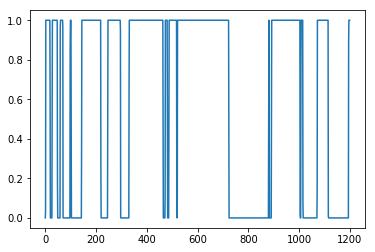

In [17]:
plt.plot(promoter_state_density)

We'll deal with noise later, but let's first ask the question of how, if we had this kind of experimental data, would we fit it? Many possible approaches, but let's try a relatively simple one.

As a first pass, let's try to estimate the number of polymerases loaded in a given interval. If we load polymerase in a time interval then it's going to generate a pulse of polymerase that lasts for polymerase_transit_time

In [18]:
bins = len(times)

polymerase_pulses = np.zeros((bins,bins))
pulse_duration = int(polymerase_transit_time / time_interval)

for i in range(0,bins):
    
    # pulse starts at i
    
    for j in range(i,min(i+pulse_duration,bins)):
        
        polymerase_pulses[i][j] = 1
    

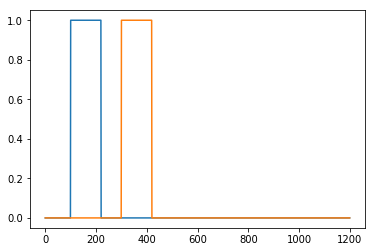

In [19]:
plt.plot(polymerase_pulses[100])
plt.plot(polymerase_pulses[300])

In [20]:
polymerase_lsq_fit = scipy.optimize.lsq_linear(polymerase_pulses.T,polymerase_density)

In [21]:
loadings = polymerase_lsq_fit['x']
datafit = np.matrix(polymerase_pulses.T) * np.matrix(loadings).T

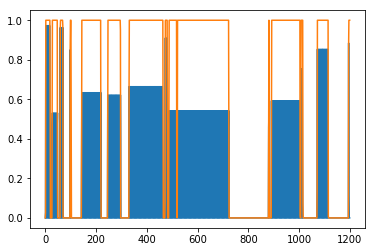

In [22]:
plt.plot(polymerase_lsq_fit['x'])
plt.plot(promoter_state_density)

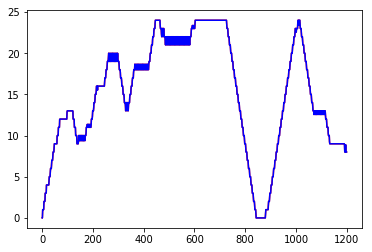

In [23]:
plt.plot(polymerase_density, c='red')
plt.plot(datafit,c='blue')

In [24]:
polymerase_density_noise = polymerase_density + np.random.normal(0,1,len(polymerase_density))

In [25]:
polymerase_noise_lsq_fit = scipy.optimize.lsq_linear(polymerase_pulses.T,polymerase_density_noise)

In [26]:
loadings = polymerase_noise_lsq_fit['x']
datafit = np.matrix(polymerase_pulses.T) * np.matrix(loadings).T

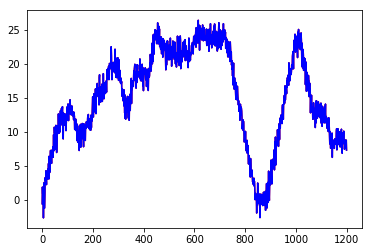

In [27]:
plt.plot(polymerase_density_noise,c='red')
plt.plot(datafit,c='blue')

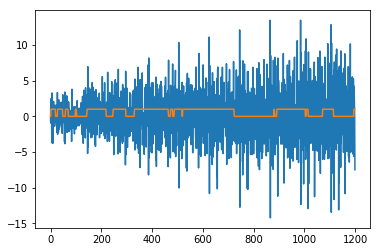

In [28]:
plt.plot(polymerase_noise_lsq_fit['x'])
plt.plot(promoter_state_density)

In [29]:
polymerase_noise_nnls = scipy.optimize.nnls(polymerase_pulses.T,polymerase_density_noise)

In [30]:
loadings = polymerase_noise_nnls[0]
datafit = np.matrix(polymerase_pulses.T) * np.matrix(loadings).T 

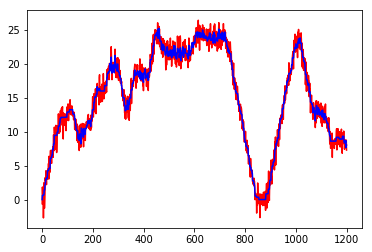

In [31]:
plt.plot(polymerase_density_noise,c='red')
plt.plot(datafit,c='blue')

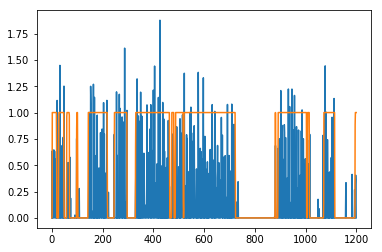

In [32]:
plt.plot(loadings)
plt.plot(promoter_state_density)

In [33]:
# what about if we sample the data at different intervals?

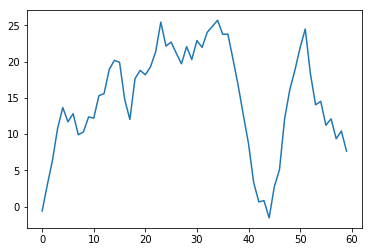

In [34]:
polymerase_density_noise_20 = [polymerase_density_noise[i] for i in range(0,len(polymerase_density_noise),20)]
plt.plot(polymerase_density_noise_20)


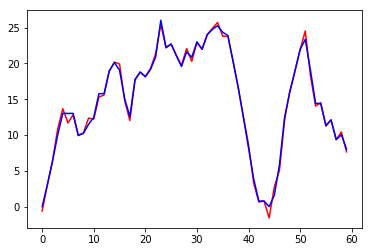

In [35]:
bins = len(polymerase_density_noise_20)

polymerase_pulses = np.zeros((bins,bins))
pulse_duration = int(polymerase_transit_time / 20)

for i in range(0,bins):
    
    # pulse starts at i
    
    for j in range(i,min(i+pulse_duration,bins)):
        
        polymerase_pulses[i][j] = 1
    
polymerase_noise20_nnls = scipy.optimize.nnls(polymerase_pulses.T,polymerase_density_noise_20)
loadings = polymerase_noise20_nnls[0]
datafit = np.matrix(polymerase_pulses.T) * np.matrix(loadings).T 

plt.plot(polymerase_density_noise_20,c='red')
plt.plot(datafit,c='blue')

In [36]:
promoter_state_density_20 = [promoter_state_density[i] for i in range(0,len(promoter_state_density),20)]

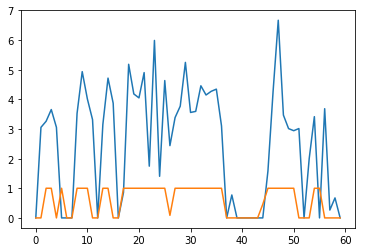

In [37]:
plt.plot(loadings)
plt.plot(promoter_state_density_20)

In [38]:
import pulp
from pulp import *

In [48]:
d = polymerase_density

bh = 1
bw = 120

datalen = len(d)
data_indices = [i for i in range(0,datalen)]

basis_vectors = []
for x in range(0,datalen):
    basis_vector = datalen * [0]
    for i in range(x,min(x+bw,datalen)):
        basis_vector[i] = bh 
    basis_vectors.append(np.array(basis_vector))

basis_indices = [i for i in range(len(basis_vectors))]

basis_loadings = [LpVariable("Basis vector " + str(b),0,1,cat="Integer") for b in basis_indices]
err = [LpVariable("err " + str(i),0,None,cat="Continuous") for i in data_indices]

loadshifts = []

prob = LpProblem("Fit MS2 Pulses",LpMinimize)   

prob += sum([err[i] for i in data_indices]) 

for i in data_indices:
    prob += d[i] - sum([basis_loadings[j] * basis_vectors[j][i] for j in basis_indices]) <= err[i]
    prob += d[i] - sum([basis_loadings[j] * basis_vectors[j][i] for j in basis_indices]) >= -err[i]

cbc = "/usr/local/bin/cbc"
prob.solve(COIN_CMD(path=cbc, mip=1, maxSeconds=120, threads=4))

fitdata = datalen * [0]
fitdata = np.array(fitdata)

basis_loading_vector = np.zeros(datalen)

for b in basis_indices:
    if basis_loadings[b].varValue == 1.0:
        fitdata += basis_vectors[b]
        basis_loading_vector[b] = 1

In [49]:
for b in basis_indices:
    print (basis_loadings[b].varValue)

0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0


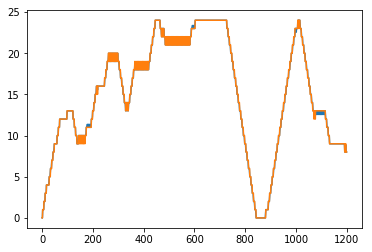

In [52]:
plt.plot(d)
plt.plot(fitdata)

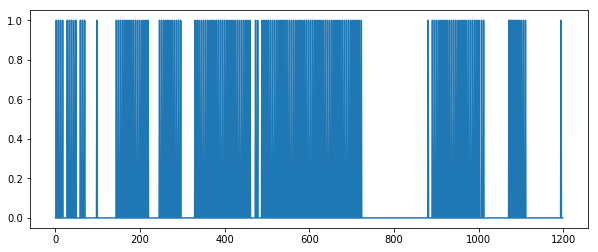

In [54]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(basis_loading_vector)

In [55]:
d = polymerase_density_noise

bh = 1
bw = 120

datalen = len(d)
data_indices = [i for i in range(0,datalen)]

basis_vectors = []
for x in range(0,datalen):
    basis_vector = datalen * [0]
    for i in range(x,min(x+bw,datalen)):
        basis_vector[i] = bh 
    basis_vectors.append(np.array(basis_vector))

basis_indices = [i for i in range(len(basis_vectors))]

basis_loadings = [LpVariable("Basis vector " + str(b),0,1,cat="Integer") for b in basis_indices]
err = [LpVariable("err " + str(i),0,None,cat="Continuous") for i in data_indices]

loadshifts = []

prob = LpProblem("Fit MS2 Pulses",LpMinimize)   

prob += sum([err[i] for i in data_indices]) 

for i in data_indices:
    prob += d[i] - sum([basis_loadings[j] * basis_vectors[j][i] for j in basis_indices]) <= err[i]
    prob += d[i] - sum([basis_loadings[j] * basis_vectors[j][i] for j in basis_indices]) >= -err[i]

cbc = "/usr/local/bin/cbc"
prob.solve(COIN_CMD(path=cbc, mip=1, maxSeconds=120, threads=4))

fitdata_noise = datalen * [0]
fitdata_noise = np.array(fitdata_noise)

basis_loading_vector_noise = np.zeros(datalen)

for b in basis_indices:
    if basis_loadings[b].varValue == 1.0:
        fitdata_noise += basis_vectors[b]
        basis_loading_vector_noise[b] = 1

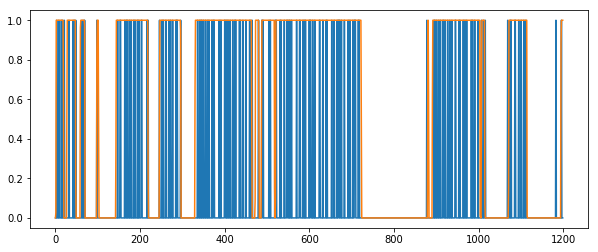

In [58]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(basis_loading_vector_noise)
ax.plot(promoter_state_density)

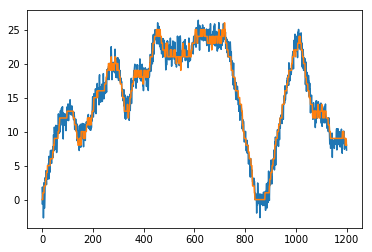

In [57]:
plt.plot(d)
plt.plot(fitdata_noise)